In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from itertools import chain
import gc
from sklearn.exceptions import NotFittedError

### Import pre-processed undersampled data

In [33]:
train=pd.read_csv("C:/Users/nisha/Downloads/Heart_Disease_Prediction_Data/Undersampled_data")

In [41]:
train.drop(['Unnamed: 0'], axis=1, inplace=True)
train.shape

(4362, 491)

In [10]:
train.head()

,AGE,RECON_MA_RISK_SCORE_NBR,RECON_RX_RISK_SCORE_NBR,Length_residence,Est_BMI_decile,Num_person_household,Online_purchaser,Online_User,Pct_above_poverty_line,Pct_below_poverty_line,...,COL_GAP,AMM,AMM_GAP,DIAB_PASS,ACE_PASS,STATIN_PASS,ACE_ELIG,DIAB_ELIG,STATIN_ELIG,AMI_FLAG
0,0.126557,-0.579759,-0.321175,1.966651e-16,0.000000,0.000000,-7.370832e-17,0.000000,-1.525278e-15,-3.936114e-16,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0
1,-1.314445,-0.229132,0.869726,-5.932796e-01,0.292793,4.691423,-5.376197e-01,0.803711,-7.313887e-01,7.652757e-01,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2,-1.623231,-0.342135,-0.406899,1.966651e-16,0.000000,0.000000,-7.370832e-17,0.000000,-1.525278e-15,-3.936114e-16,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.285158,2.467107,-0.004657,1.966651e-16,0.000000,0.000000,-7.370832e-17,0.000000,-1.525278e-15,-3.936114e-16,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-1.108587,-0.312564,-0.249958,-5.379233e-01,-0.525492,0.975757,-5.376197e-01,-1.416778,3.419306e-01,-3.426419e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


### Class for Feature Selection

In [13]:
import lightgbm as lgb

class FeatureSelect():
    def __init__(self):
        
        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None
        
        self.feature_importances = None
        
        # Dictionary to hold removal operations
        self.removal_ops = {}
    
    def identify_missing(self, data, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""
        
        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column 
        missing_series = data.isnull().sum() / data.shape[0]
        
        self.missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.removal_ops['missing'] = to_drop
        
        print('%d features with greater than %0.2f missing values.\n' % (len(self.removal_ops['missing']), self.missing_threshold))
        
    def identify_single_unique(self, data):
        """Identifies features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = data.nunique()

        self.unique_stats = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})
        
        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})

        to_drop = list(record_single_unique['feature'])
    
        self.record_single_unique = record_single_unique
        self.removal_ops['single_unique'] = to_drop
        
        print('%d features with a single unique value.\n' % len(self.removal_ops['single_unique']))
        
    def identify_collinear(self, data, correlation_threshold):
        """
        Finds collinear features based on the correlation coefficient between features. 
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal. 

        """
        
        self.correlation_threshold = correlation_threshold

        # Calculate the correlations between every column
        corr_matrix = data.corr()
        
        self.corr_matrix = corr_matrix
    
        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        
        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop
        for column in to_drop:

            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})
            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

            
        self.record_collinear = record_collinear
        self.removal_ops['collinear'] = to_drop
        
        print('%d features with a correlation greater than %0.2f.\n' % (len(self.removal_ops['collinear']), self.correlation_threshold))
        
        
    def identify_zero_importance(self, features, labels, eval_metric, task='classification', 
                                 n_iterations=10, early_stopping = True):
        """
        
        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting. 
        The feature importances are averaged over n_iterations to reduce variance. 
        
        Uses the LightGBM implementation (http://lightgbm.readthedocs.io/en/latest/index.html)"""
        # One hot encoding
        features = pd.get_dummies(features)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(labels).reshape((-1, ))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
        
        print('Training Gradient Boosting Model\n')
        
        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = lgb.LGBMClassifier(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            elif task == 'regression':
                model = lgb.LGBMRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            else:
                raise ValueError('Task must be either "classification" or "regression"')
                
            # If training using early stopping need a validation set
            if early_stopping:
                
                train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, test_size = 0.15)

                # Train the model with early stopping
                model.fit(train_features, train_labels, eval_metric = eval_metric,
                          eval_set = [(valid_features, valid_labels)],
                          early_stopping_rounds = 100, verbose = -1)
                
                # Clean up memory
                gc.enable()
                del train_features, train_labels, valid_features, valid_labels
                gc.collect()
                
            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]
        
        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.removal_ops['zero_importance'] = to_drop
        
        print('\n%d features with zero importance.\n' % len(self.removal_ops['zero_importance']))
    
    def identify_low_importance(self, cumulative_importance):
        self.cumulative_importance = cumulative_importance
        # The feature importances need to be calculated before running
        if self.feature_importances is None:
                raise NotFittedError('Feature importances have not yet been determined. Call the `identify_zero_importance` method` first.')

            # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

            # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.removal_ops['low_importance'] = to_drop

        print('%d features that do not contribute to cumulative importance of %0.2f.\n' % (len(self.removal_ops['low_importance']), self.cumulative_importance))
    
    def identify_all(self, features, labels, selection_params):
        """
            Use all five of the methods to identify features to remove.
        """
     # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method' % param)

            # Implement each of the five methods
        self.identify_missing(features, selection_params['missing_threshold'])
        self.identify_single_unique(features)
        self.identify_collinear(features, selection_params['correlation_threshold'])
        self.identify_zero_importance(features, labels, selection_params['eval_metric'], selection_params['task'])
        self.identify_low_importance(selection_params['cumulative_importance'])

            # Find the number of features identified to drop
        self.n_identified = len(set(list(chain(*list(self.removal_ops.values())))))
        print('%d total features out of %d identified for removal.\n' % (self.n_identified, pd.get_dummies(features).shape[1]))
    
    def check_identified(self):
        """Check the identified features before removal. Returns a set of the unique features identified."""
        
        all_identified = set(list(chain(*list(self.removal_ops.values()))))
        print('%d features identified for removal' % len(all_identified))
        
        return all_identified
    
    def remove(self, data, methods):
        features_to_drop = []

        data = pd.get_dummies(data)

        if methods == 'all':

            print('{} methods have been run'.format(list(self.removal_ops.keys())))

                # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.removal_ops.values()))))

        else:
            # Iterate through the specified methods
            for method in methods:
                # Check to make sure the method has been run
                if method not in self.removal_ops.keys():
                    raise NotFittedError('%s method has not been run' % method)

                    # Append the features identified for removal
                else:
                    features_to_drop.append(self.removal_ops[method])

                # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))

            # Remove the features and return the data
        data = data.drop(columns = features_to_drop)
        self.removed_features = features_to_drop
        print('Removed %d features' % len(features_to_drop))
        return data   
    
    def plot_missing(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")
        
        self.reset_plot()
        self.missing_stats.plot.hist(color = 'red', edgecolor = 'k', figsize = (6, 4), fontsize = 14)
        plt.ylabel('Frequency', size = 18)
        plt.xlabel('Missing Fraction', size = 18); plt.title('Missing Fraction Histogram', size = 18);
    
    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')
        
        self.reset_plot()
        self.unique_stats.plot.hist(edgecolor = 'k', figsize = (6, 4), fontsize = 14)
        plt.ylabel('Frequency', size = 18)
        plt.xlabel('Unique Values', size = 18); plt.title('Unique Values Histogram', size = 18);
        
    def plot_collinear(self):
        if self.record_collinear is None:
                raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')

            # Identify the correlations that were above the threshold
        corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])), 
                                                    list(set(self.record_collinear['drop_feature']))]

            # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(10, 8))

            # Generate a custom diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

            # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                        linewidths=.25, cbar_kws={"shrink": 0.6})

        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));

        plt.xlabel('Features to Remove', size = 8); plt.ylabel('Correlated Feature', size = 8)
        plt.title("Correlations Above Threshold", size = 14)
        
    def plot_feature_importances(self, threshold = None):
        """
        Plots 15 most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.

        Parameters
        --------
        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances

        """
        
        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')

        self.reset_plot()
        
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        ax.barh(list(reversed(list(self.feature_importances.index[:15]))), 
                self.feature_importances['normalized_importance'].head(15), 
                align = 'center', edgecolor = 'k')
        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:15]))))
        ax.set_yticklabels(self.feature_importances['feature'].head(15), size = 12)

        # Plot labeling
        plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features', size = 14); plt.ylabel('Cumulative Importance', size = 14); 
        plt.title('Cumulative Feature Importance', size = 16);

        if threshold:

            # Index of minimum number of features needed for cumulative importance threshold
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x = importance_index + 1, ymin = 0, ymax = 1, linestyles='--', colors = 'blue')
            plt.show()

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault

#### Initializing object from above class

In [14]:
fs = FeatureSelect()

### Feature Selection

#### Single unique values - find any features that have a single unique value

60 features with a single unique value.



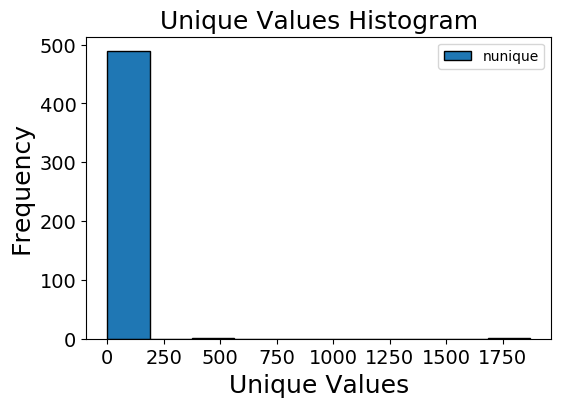

In [15]:
fs.identify_single_unique(train)
fs.plot_unique()

#### Subsetting numeric columns to find correlation

In [16]:
# Separate string columns
cols_string1 = ['SEX_CD', 'ESRD_IND', 'HOSPICE_IND', 'ORIG_REAS_ENTITLE_CD', 'PCP_ASSIGNMENT','Diab_Type','DUAL','Dwelling_Type','Education_level','INSTITUTIONAL','LIS','MCO_HLVL_PLAN_CD','MCO_PROD_TYPE_CD']

# Separate numeric columns
cols_numeric = [x for x in train.columns if x not in cols_string1]
cols_numeric = [x for x in cols_numeric if x not in ['AMI_FLAG', 'ID']]

#### Highly Correlated Features

#### Find pairs of collinear features based on the Pearson correlation coefficient 
#### Threshold - 99%

19 features with a correlation greater than 0.99.



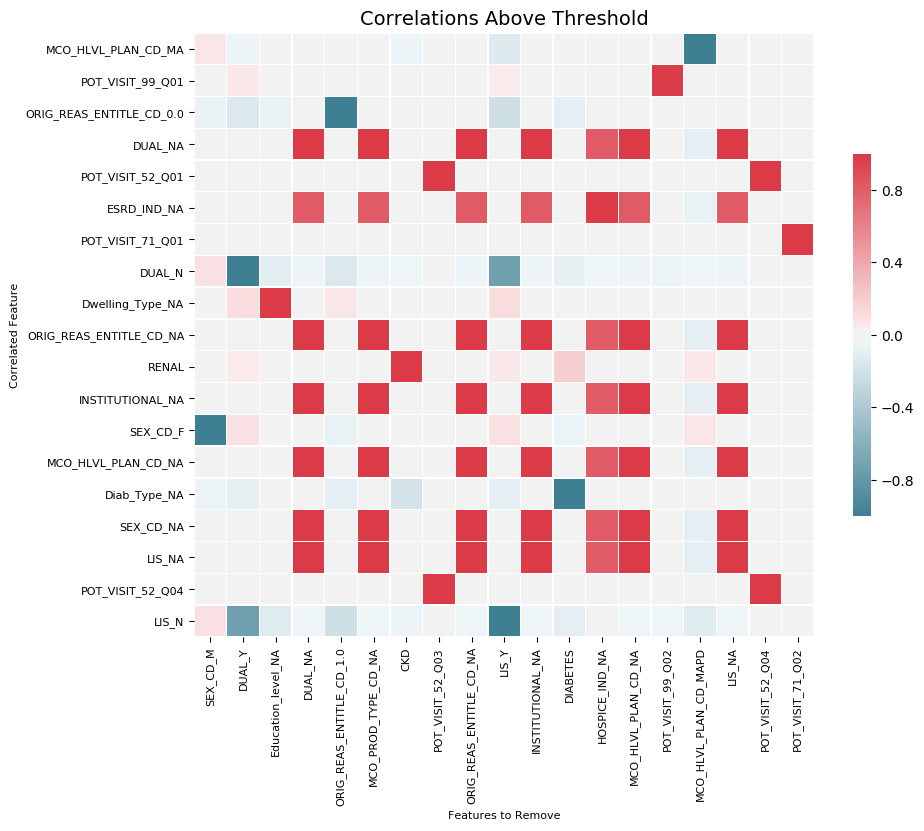

In [18]:
fs.identify_collinear(train[cols_numeric], 0.99)
fs.plot_collinear()

#### Threshold - 99%

29 features with a correlation greater than 0.90.



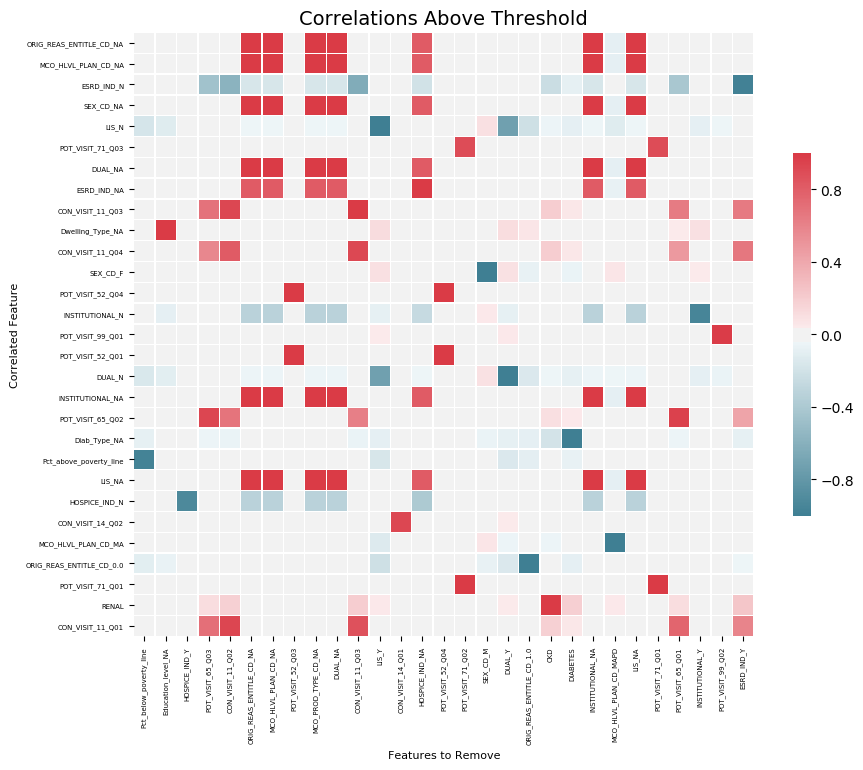

In [19]:
fs.identify_collinear(train[cols_numeric], 0.90)
fs.plot_collinear()

### Features with zero-importance

This method relies on lightGBM model to identify features to remove. To reduce variance in the calculated feature importances, the model is trained a default 10 times. 

The following parameters can be passed to the identify_zero_importance method:

task: either classification or regression. 
eval_metric: the metric used for early stopping (for example auc for classification or l2 for regression).
n_iterations: number of training runs
early_stopping: whether to use early stopping when training the model (default = True) when the performance on a validation set no longer decreases for a specified number of estimators and prevent overfitting

In [34]:
labels = train['AMI_FLAG']
train.drop(['AMI_FLAG'],axis=1,inplace=True)

In [21]:
fs.identify_zero_importance(train, labels, eval_metric='auc')

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.594234	valid_0's auc: 0.75087
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.608913	valid_0's auc: 0.736043
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.610301	valid_0's auc: 0.732337
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.589531	valid_0's auc: 0.75317
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.604143	valid_0's auc: 0.754922
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.582142	valid_0's auc: 0.763

### Plot Feature Importances

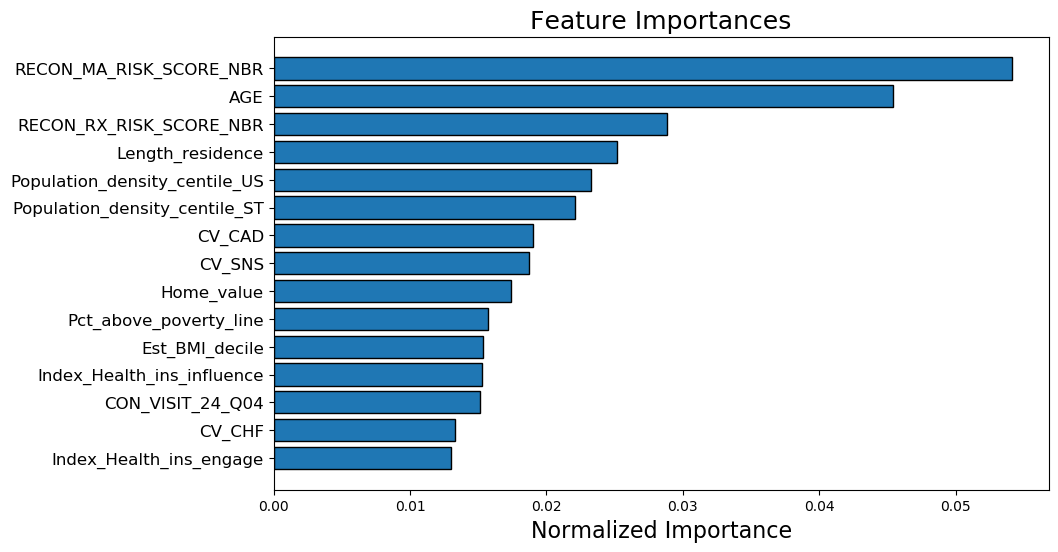

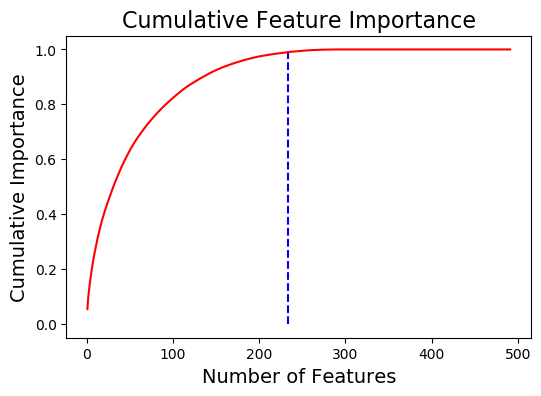

233 features required for 0.99 of cumulative importance


In [22]:
fs.plot_feature_importances(threshold = 0.99)

### Low-Importance Features

In [23]:
fs.identify_low_importance(0.99)

259 features that do not contribute to cumulative importance of 0.99.



#### Let us look at the summary of Features to be removed

In [24]:
fs.identify_all(train, labels, {'missing_threshold': 0.9, 'correlation_threshold': 0.95, 'eval_metric': 'auc',
                                      'task': 'classification', 'cumulative_importance': 0.95})

0 features with greater than 0.90 missing values.

60 features with a single unique value.

22 features with a correlation greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.572612	valid_0's auc: 0.775524
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.610109	valid_0's auc: 0.734089
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.604427	valid_0's auc: 0.741366
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.598389	valid_0's auc: 0.746104
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.608722	valid_0's auc: 0.731485
Training unti

#### Removing features and forming the final training dataset

In [59]:
final = fs.remove(data=train,methods = 'all')

['single_unique', 'collinear', 'zero_importance', 'low_importance', 'missing'] methods have been run
Removed 324 features


In [65]:
#final['AMI_FLAG'] = labels
final.to_csv("C:/Users/nisha/Downloads/Heart_Disease_Prediction_Data/final_undersampled.csv")

In [66]:
final.head()

,AGE,RECON_MA_RISK_SCORE_NBR,RECON_RX_RISK_SCORE_NBR,Length_residence,Est_BMI_decile,Num_person_household,Online_purchaser,Online_User,Pct_above_poverty_line,Decile_struggle_Med_lang,...,CDC_HBAPOOR_GAP,BCS,COL,COL_GAP,DIAB_PASS,ACE_PASS,STATIN_PASS,ACE_ELIG,STATIN_ELIG,AMI_FLAG
0,0.126557,-0.579759,-0.321175,1.966651e-16,0.000000,0.000000,-7.370832e-17,0.000000,-1.525278e-15,3.752392e-16,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0
1,-1.314445,-0.229132,0.869726,-5.932796e-01,0.292793,4.691423,-5.376197e-01,0.803711,-7.313887e-01,-2.091043e+00,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0
2,-1.623231,-0.342135,-0.406899,1.966651e-16,0.000000,0.000000,-7.370832e-17,0.000000,-1.525278e-15,3.752392e-16,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.285158,2.467107,-0.004657,1.966651e-16,0.000000,0.000000,-7.370832e-17,0.000000,-1.525278e-15,3.752392e-16,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,-1.108587,-0.312564,-0.249958,-5.379233e-01,-0.525492,0.975757,-5.376197e-01,-1.416778,3.419306e-01,1.288811e+00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
